<>:79: SyntaxWarning: invalid escape sequence '\c'
<>:79: SyntaxWarning: invalid escape sequence '\c'
C:\Users\valen\AppData\Local\Temp\ipykernel_5776\3448305118.py:79: SyntaxWarning: invalid escape sequence '\c'
  ax1.set_ylabel('Temperatura ($^{\circ}$C)', fontsize=14)


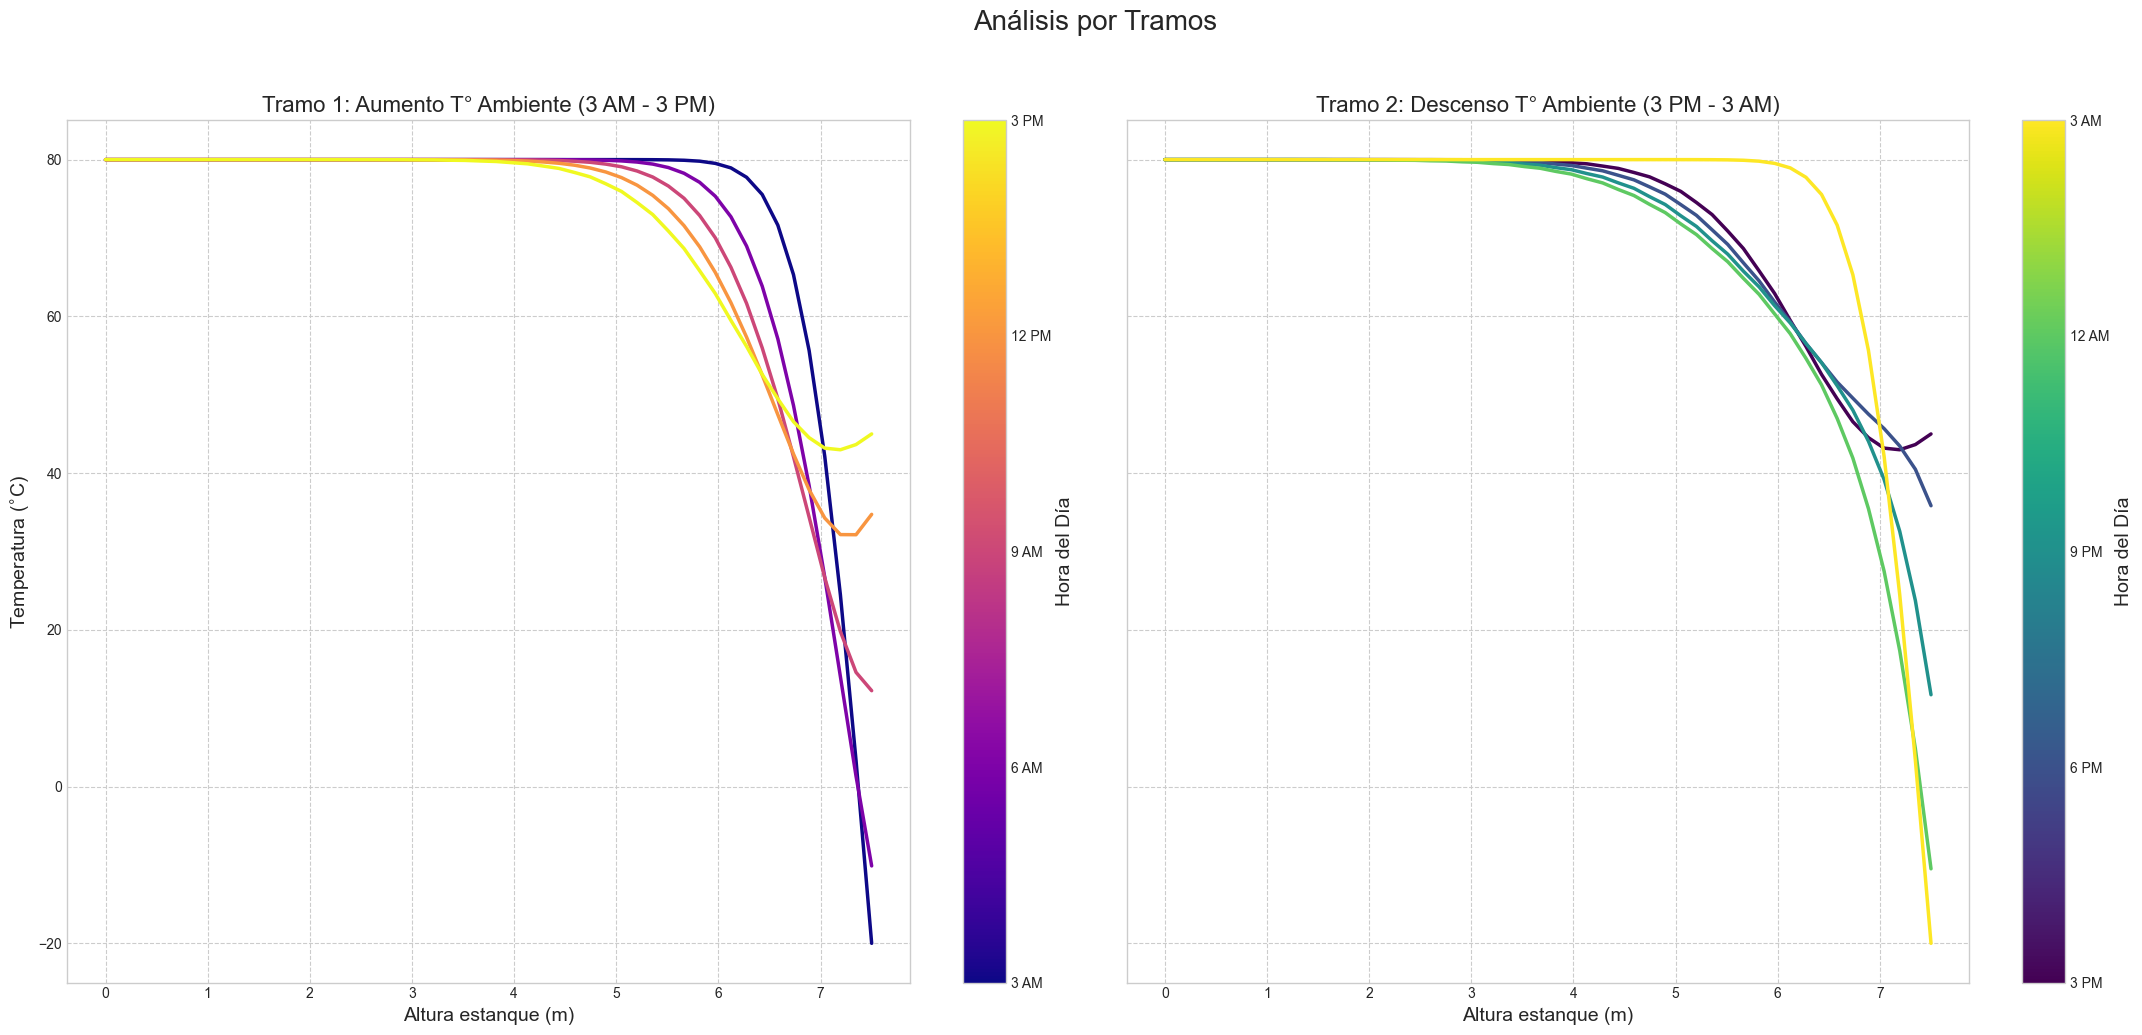

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('seaborn-v0_8-whitegrid')

def model(t, T, k, rho, cp, L, N):
    
    #Parámetros
    alpha = k / (rho * cp)
    dx = L / (N - 1)
    

    T_mean = 12.5
    A = 32.5
    tau = 24 * 3600
    shift_seconds = 3 * 3600 
    T_superficie = T_mean - A * np.cos(2 * np.pi * (t - shift_seconds) / tau)
    
    #Vector de Derivadas (dT/dt)
    dTdt = np.zeros(N - 1)
    dTdt[0] = 2.0 * alpha * (T[1] - T[0]) / (dx**2)
    for i in range(1, N - 2):
        dTdt[i] = alpha * (T[i+1] - 2*T[i] + T[i-1]) / (dx**2)
    dTdt[N-2] = alpha * (T_superficie - 2*T[N-2] + T[N-3]) / (dx**2)
    
    return dTdt

#Parámetros Comunes de Simulación (Aceite Térmico) 
rho = 778
cp = 2355
L = 7.5
N = 50
x_plot = np.linspace(0, L, N)
T_inicial_uniforme = 80.0
T_vec_inicial = np.full(N - 1, T_inicial_uniforme)
t_inicio = 0
t_fin = 1 * 24 * 3600
t_puntos = np.linspace(t_inicio, t_fin, 100)

#Simulación k Efectivo
k_base = 0.125
k_efectivo = k_base * 200  # k = 25.0

sol_efectivo = solve_ivp(
    fun=model,
    t_span=(t_inicio, t_fin),
    y0=T_vec_inicial,
    t_eval=t_puntos,
    method='RK45',
    args=(k_efectivo, rho, cp, L, N)
)


#Graficar en 2 tramos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), sharey=True) 

T_mean = 12.5
A = 32.5
tau = 24 * 3600
shift_seconds = 3 * 3600

#Tramo 1
tiempos_aumento_h = np.arange(3, 15 + 3, 3)
cmap_aumento = plt.cm.plasma
norm_aumento = plt.Normalize(vmin=min(tiempos_aumento_h), vmax=max(tiempos_aumento_h))

for t_h in tiempos_aumento_h:
    t_idx = np.argmin(np.abs(sol_efectivo.t - t_h * 3600))
    T_perfil_parcial = sol_efectivo.y[:, t_idx]
    t_s = sol_efectivo.t[t_idx]
    T_superficie = T_mean - A * np.cos(2 * np.pi * (t_s - shift_seconds) / tau)
    T_perfil_completo = np.append(T_perfil_parcial, T_superficie)
    ax1.plot(x_plot, T_perfil_completo, color=cmap_aumento(norm_aumento(t_h)), linewidth=2.5) 

ax1.set_title('Tramo 1: Aumento T° Ambiente (3 AM - 3 PM)', fontsize=16)
ax1.set_xlabel('Altura estanque (m)', fontsize=14)
ax1.set_ylabel('Temperatura ($^{\circ}$C)', fontsize=14)
ax1.grid(True, linestyle='--')

sm1 = plt.cm.ScalarMappable(cmap=cmap_aumento, norm=norm_aumento)
cbar1 = fig.colorbar(sm1, ax=ax1)
cbar1.set_label('Hora del Día', fontsize=14)
cbar1.set_ticks([3, 6, 9, 12, 15]) #Los valores de datos
cbar1.set_ticklabels(['3 AM', '6 AM', '9 AM', '12 PM', '3 PM']) #Las etiquetas

#Tramo 2
tiempos_descenso_h_map = {15: 15, 18: 18, 21: 21, 24: 24, 3: 27} 
cmap_descenso = plt.cm.viridis
norm_descenso = plt.Normalize(vmin=15, vmax=27) 

for t_h_real, t_h_color in tiempos_descenso_h_map.items():
    t_idx = np.argmin(np.abs(sol_efectivo.t - t_h_real * 3600))
    T_perfil_parcial = sol_efectivo.y[:, t_idx]
    t_s = sol_efectivo.t[t_idx]
    T_superficie = T_mean - A * np.cos(2 * np.pi * (t_s - shift_seconds) / tau)
    T_perfil_completo = np.append(T_perfil_parcial, T_superficie)
    ax2.plot(x_plot, T_perfil_completo, color=cmap_descenso(norm_descenso(t_h_color)), linewidth=2.5)

ax2.set_title('Tramo 2: Descenso T° Ambiente (3 PM - 3 AM)', fontsize=16)
ax2.set_xlabel('Altura estanque (m)', fontsize=14)
ax2.grid(True, linestyle='--')

sm2 = plt.cm.ScalarMappable(cmap=cmap_descenso, norm=norm_descenso)
cbar2 = fig.colorbar(sm2, ax=ax2)
cbar2.set_label('Hora del Día', fontsize=14)
cbar2.set_ticks([15, 18, 21, 24, 27]) #Los valores 
cbar2.set_ticklabels(['3 PM', '6 PM', '9 PM', '12 AM', '3 AM']) #Las etiquetas 

#Ajustes Finales
plt.ylim(-25, 85)
plt.suptitle('Análisis por Tramos', fontsize=20, y=1.03)
plt.tight_layout()
plt.savefig('T_profile_k_aumentado_etiquetas_corregidas.png')
